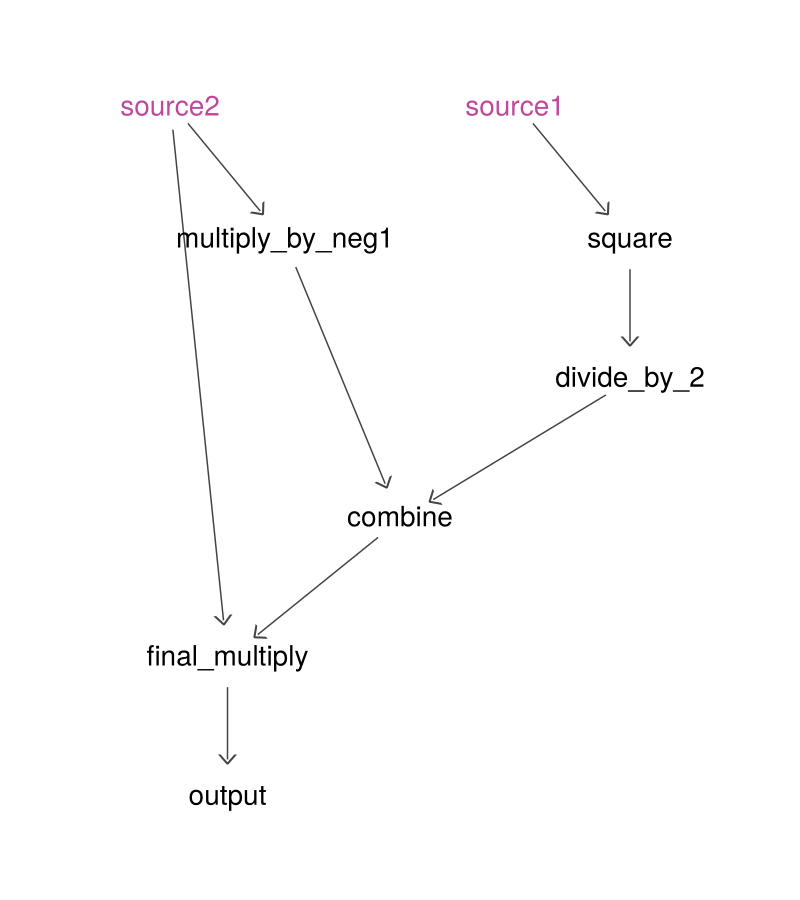

In [3]:
using Colors
using CairoMakie
using GraphMakie
using Graphs
using LayeredLayouts

function visualize_graph(graph::StreamGraph)
    nodes = graph.nodes
    g = SimpleDiGraph(length(nodes))
    nlabels = String[]
    node_colors = []
    
    # Create a mapping from node IDs to graph indices
    zero_levels = Vector{Pair{Int, Int}}()
    nlabels_align = []
    nlabels_color = []

    for (i, node) in enumerate(nodes)
        node_id = node.index
        push!(nlabels, node.label)
        if is_source(node)
            push!(node_colors, colorant"#ffdd33")  # yellow for source nodes
            push!(zero_levels, i => 1) # source layers always at level 1
            push!(nlabels_align, (:center, :bottom))
            push!(nlabels_color, colorant"#bf489d")
        else
            push!(node_colors, colorant"#b4dee8")  # light blue for compute nodes
            push!(nlabels_align, (:center, :top))
            push!(nlabels_color, colorant"#000000")
        end
        
        for dep_id in graph.dependencies[node_id]
            add_edge!(g, nodes[dep_id].index, nodes[node_id].index)
        end
    end

    xs, ys, paths = solve_positions(Zarate(), g; force_layer=zero_levels)
    xs, ys = -ys, -xs # rotate coordinates by 90°
    ys .*= 0.3 # scale the y coordinates
    lay = Point.(zip(xs, ys))

    f, ax, p = graphplot(g;
        layout=lay,
        arrow_size=15,
        arrow_shift=:end,
        arrow_marker='>',
        edge_width=0.75,
        edge_color=colorant"#444",
        # node_color=node_colors,
        # node_size=48,
        nlabels=nlabels,
        nlabels_fontsize=14,
        nlabels_align=nlabels_align,
        nlabels_color=nlabels_color,
        # nlabels_distance=12,
        node_size=40,
        node_color=:white,
        nlabels_distance=-10,
    )
    hidedecorations!(ax)
    hidespines!(ax)

    # add some padding
    x_range, y_range = extrema(xs), extrema(ys)
    x_range, y_range = x_range[2] - x_range[1], y_range[2] - y_range[1]
    xlims!(ax, minimum(xs) - 0.3x_range, maximum(xs) + 0.3x_range)
    ylims!(ax, minimum(ys) - 0.1y_range, maximum(ys) + 0.1y_range)

    # adjust width to match aspect ratio
    resize!(f, floor(Int, size(f.scene)[2]*(x_range / y_range)), size(f.scene)[2])
    
    f, ax, p
end

f, ax, p = visualize_graph(g)

# Save the plot to a file
# save("computation_graph.png", f)

display(f);

In [2]:
using DataStructures
using Dates

mutable struct StreamNode{G}
    graph::G
    index::Int
    func::Function
    inputs::Vector{StreamNode}
    last_value::Any
    label::String
end

@inline is_source(node::StreamNode) = isempty(node.inputs)

struct Event
    timestamp::DateTime
    source_index::Int
end

@inline Base.isless(a::Event, b::Event) = a.timestamp < b.timestamp

mutable struct StreamGraph
    nodes::Vector{StreamNode{StreamGraph}}
    dependencies::Vector{Vector{Int}}
    reverse_dependencies::Vector{Vector{Int}}
    topological_order::Vector{Int}

    function StreamGraph()
        new(
            StreamNode{StreamGraph}[],
            Vector{Int}[],
            Vector{Int}[],
            Int[]
        )
    end
end

mutable struct Executor
    graph::StreamGraph
    simulation_heap::BinaryMinHeap{Event}
    current_time::DateTime

    function Executor(graph::StreamGraph)
        new(
            graph,
            BinaryMinHeap{Event}(),
            DateTime(2000, 1, 1)
        )
    end
end

function node!(graph::StreamGraph, func::Function; label::String="")
    if isempty(label)
        # label = string(func)
        buffer = IOBuffer()
        Base.show_unquoted(buffer, func)
        label = String(take!(buffer))
    end
    index = length(graph.nodes) + 1
    node = StreamNode{StreamGraph}(
        graph,
        index,
        func,
        StreamNode{StreamGraph}[],
        nothing,
        label)
    push!(graph.nodes, node)
    push!(graph.dependencies, Int[])
    push!(graph.reverse_dependencies, Int[])
    node
end

function bind_inputs!(graph::StreamGraph, node::StreamNode, inputs)
    node.inputs = collect(inputs)
    input_indices = [input.index for input in node.inputs]
    graph.dependencies[node.index] = input_indices
    for input_index in input_indices
        push!(graph.reverse_dependencies[input_index], node.index)
    end
end

# syntactic sugar for binding inputs (bind_inputs!)
function Base.:|>(inputs, node::StreamNode{G}) where {G}
    for (i, input) in enumerate(inputs)
        if !(input isa StreamNode)
            error("Input #$i is not a StreamNode")
        end
    end
    bind_inputs!(node.graph, node, collect(StreamNode, inputs))
    node
end

function topological_sort!(graph::StreamGraph)
    in_degree = [length(deps) for deps in graph.dependencies]
    queue = Int[]

    for (index, degree) in enumerate(in_degree)
        if degree == 0
            push!(queue, index)
        end
    end

    sorted_order = Int[]

    while !isempty(queue)
        node_index = pop!(queue)
        push!(sorted_order, node_index)

        for dependent_index in graph.reverse_dependencies[node_index]
            in_degree[dependent_index] -= 1
            if in_degree[dependent_index] == 0
                push!(queue, dependent_index)
            end
        end
    end

    if length(sorted_order) != length(graph.nodes)
        error("Graph has a cycle")
    end

    graph.topological_order = sorted_order

    nothing
end

function execute_node!(executor::Executor, node::StreamNode{StreamGraph}, is_event_source::Bool)
    if is_source(node)
        node.last_value = is_event_source ? node.func(executor.current_time, executor, node) : node.last_value
    else
        input_values = (input.last_value for input in node.inputs)
        node.last_value = any(isnothing, input_values) ? nothing : node.func(executor.current_time, input_values...)
    end
    
    nothing
end

function process_subgraph!(executor::Executor, start_node_index::Int)
    queue = PriorityQueue{Int,Int}()
    enqueue!(queue, start_node_index => 0)
    depths = Dict(start_node_index => 0)

    while !isempty(queue)
        node_index = dequeue!(queue)
        is_event_source = (node_index == start_node_index)
        execute_node!(executor, executor.graph.nodes[node_index], is_event_source)

        current_depth = depths[node_index]
        for dependent_index in executor.graph.reverse_dependencies[node_index]
            new_depth = current_depth + 1
            if get(depths, dependent_index, -1) < new_depth
                depths[dependent_index] = new_depth
                if haskey(queue, dependent_index)
                    queue[dependent_index] = -new_depth
                else
                    enqueue!(queue, dependent_index => -new_depth)
                end
            end
        end
    end

    nothing
end

function run_simulation!(executor::Executor)
    for node in executor.graph.nodes
        if is_source(node)
            execute_node!(executor, node, true)
        end
    end

    while !isempty(executor.simulation_heap)
        event = pop!(executor.simulation_heap)
        executor.current_time = event.timestamp
        process_subgraph!(executor, event.source_index)
    end

    nothing
end

function create_list_source(data::D) where {D<:AbstractVector}
    current_index = Ref(1)

    function source_func(time::DateTime, executor::Executor, node::StreamNode{StreamGraph})
        if current_index[] <= length(data)
            timestamp, output = data[current_index[]]
            current_index[] += 1
            if current_index[] <= length(data)
                next_timestamp, _ = data[current_index[]]
                push!(executor.simulation_heap, Event(next_timestamp, node.index))
            end
            return output
        end
        nothing
    end

    source_func
end

# Example usage
g = StreamGraph()

# Create source nodes
source1 = node!(g, create_list_source([
        (DateTime(2000, 1, 1, 0, 0, 1), 2),
        (DateTime(2000, 1, 1, 0, 0, 3), 4),
        (DateTime(2000, 1, 1, 0, 0, 5), 6)
    ]), label="source1")
source2 = node!(g, create_list_source([
        (DateTime(2000, 1, 1, 0, 0, 2), 10),
        (DateTime(2000, 1, 1, 0, 0, 4), 20),
        (DateTime(2000, 1, 1, 0, 0, 6), 30)
    ]), label="source2")

# Create compute nodes
square = node!(g, (time, x) -> x^2; label="square") # x^2
divide_by_2 = node!(g, (time, x) -> x / 2, label="divide_by_2")
multiply_by_neg1 = node!(g, (time, x) -> -x, label="multiply_by_neg1")
combine = node!(g, (time, x, y) -> (x, y), label="combine")
final_multiply = node!(g, (time, tuple, source2_val) -> (tuple[1] * source2_val, tuple[2] * source2_val), label="final_multiply")
output = node!(g, (time, x) -> println("Final Output at time $time: $x"), label="output")

# Bind inputs
(source1,) |> square
(square,) |> divide_by_2
(source2,) |> multiply_by_neg1
(divide_by_2, multiply_by_neg1) |> combine
(combine, source2) |> final_multiply
[final_multiply] |> output

# Perform topological sort
topological_sort!(g)

# Create executor and run simulation
executor = Executor(g)
run_simulation!(executor)

Final Output at time 2000-01-01T00:00:04: (160.0, -400)
Final Output at time 2000-01-01T00:00:05: (360.0, -400)
Final Output at time 2000-01-01T00:00:06: (540.0, -900)
